# Tuning of the PI controller

PI controller for the current in a three phase inverter

> i* → (+/-) → | C | → u → | H | → i

Pierre Haessig — May 2015

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.signal as sig

In [2]:
%matplotlib inline

In [3]:
from IPython.html.widgets import interact, interactive, FloatSlider

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## 1) Models of the inverter

Because of:
* expressing the electrical equation in the rotating dq frame
* and because of the feedforward terms

we control the inverter as two independant and equal channels, with a simple Voltage→Current transfer function:

$$ H(s) = I(s) / U(s)$$

cf. Notebook about [modeling an inverter in the dq frame](dq_inverter_model.ipynb).


### Modeling options

#### Integrator (pure inductance)

Either we consider only the inductance:
$$H(s) = \frac{1}{L s}$$

#### First order (RL circuit)

or also a parasitic resistance:

$$H(s) = \frac{1}{R + Ls} = \frac{1/R}{1 + \tau s} $$

with a time constant $\tau = L/R$

#### First order with delay

In addition, we can also consider the delay induced by the sampling of the PWM modulation.

$$\tilde{H}(s) = H(s) e^{-T_d s}$$

with $T_d \approx 1/f_{switch}$ (or 1/2 of this ?)

In [4]:
L = 2e-3 #H
R = 1 # Ohms

f_switch = 10e3 # Hz
Td = 1/f_switch

sys = sig.lti([1], [L, R])
sys

lti(
array([[-500.]]),
array([[ 1.]]),
array([[ 500.]]),
array([ 0.])
)

*Helper: Plotting function for a Bode diagram*

In [52]:
w_min = 10
w_max = 10000
w_list = np.logspace(1, 4) # ~.1s to .1ms time constants (~ 1 Hz to 1000 Hz)

phase_locator = mpl.ticker.MultipleLocator(90)

def bode_plot(w, mag, phase):
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
    ax1.set(xscale='log', ylabel='Gain (dB)')
    ax1.axes.locator_params('y', nbins=5)
    ax1.grid(True)
    ax2.set(xscale='log', ylabel=u'phase (°)', xlabel=u'puls. ω (rad/s)')
    ax2.yaxis.set_major_locator(phase_locator)
    ax2.grid(True)
    
    ax1.plot(w, mag)
    ax2.plot(w, phase)
    return ax1, ax2

### Bode diagram of the inverter

$$H = U/I$$

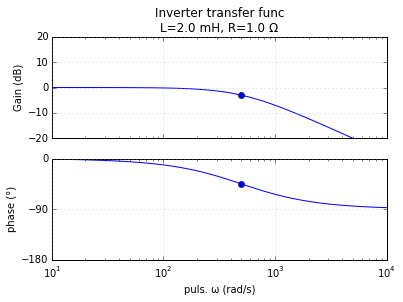

In [53]:
#L_wdg = FloatSlider(L, min=0, max=3*L)
#R_wdg = FloatSlider(L, min=0, max=3*R)

@interact(mL=[0.,2000*L], R=[0., 3*R])
def sys_bode(mL=L*1000, R=R, delay=False):  
    L = mL * 1e-3
    sys = sig.lti([1], [L, R])
    w, mag, phase = sys.bode(w_list)
    if delay:
        phase -= w_list*Td*180/np.pi
    ax1, ax2 = bode_plot(w, mag, phase)
    #ax1.plot(w, dB(1/(w*L)), 'b--', label='1/Ls asympt')
    if R>0:
        # mark the transistion frequency
        tau = L/float(R)
        ax1.plot(1/tau, -20*np.log10(R)-3, 'bo')
        ax2.plot(1/tau, -45, 'bo')
    ax1.set(title=u'Inverter transfer func \nL={:.1f} mH, R={:.1f} Ω'.format(L*1000,R))
    ax1.set_ylim(-20,20)
    ax2.set_ylim(-180, 0)
    ax2.set_xlim(w_min, w_max)

In [111]:
#L_wdg 

## 2) PI Controller

PI controller equation (other parametrizations are possible)

$$C(s) = K_p (1+\frac{1}{T_i s})$$

In [54]:
Kp = 1.
Ti = 0.01 # s

ctrl = sig.lti([Kp*Ti, Kp], [Ti, 0])
ctrl

lti(
array([[-0.]]),
array([[ 1.]]),
array([[ 100.]]),
array([ 1.])
)

### Bode diagram of the controller

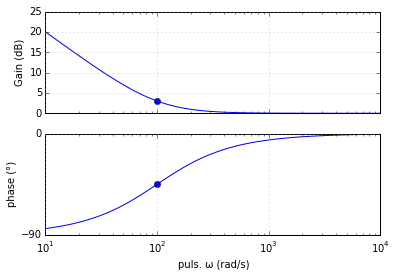

In [55]:
@interact(Kp=[0.,10], Ti=[0., Ti*10, Ti*.1])
def ctrl_bode(Kp=Kp, Ti=Ti):
    ctrl = sig.lti([Kp*Ti, Kp], [Ti, 0])
    w, mag, phase = ctrl.bode(w_list)
    ax1, ax2 = bode_plot(w, mag, phase)
    
    if Ti>0:
        # mark the transistion frequency
        ax1.plot(1/Ti, 20*np.log10(Kp)+3, 'bo')
        ax2.plot(1/Ti, -45, 'bo')
    
    ax2.grid(True)
    
    ax1

## 3) Analysis of the open loop transfer function

issue: the series connection of two systems is not implemented

In [26]:
H_ol = ctrl*sys

TypeError: unsupported operand type(s) for *: 'lti' and 'lti'

solution: do the connection in the frequency domain, manually:

In [56]:
H_ol = ctrl.freqresp(w_list)[1] * sys.freqresp(w_list)[1]

### Computing the phase margin

In [57]:
def dB(x):
    return 20*np.log10(np.abs(x))

def deg(x):
    return np.angle(x, deg=True)

In [58]:
def phase_margin(H_ol):
    'phase margin for open loop tranfer function `H_ol` (array of complex numbers)'
    # frequency of crossing 0dB
    i1 = np.nonzero(dB(H_ol)>0)[0][-1] # last index with gain above 0dB
    i2 = np.nonzero(dB(H_ol)<0)[0][0] # first index with gain below
    
    i_0dB = i2
    
    #w_cross = w[i_0dB]
    margin = 180 + deg(H_ol[i_0dB])
    return margin, i_0dB

phase_margin(H_ol)

(131.55136925956756, 23)

### Plot of the open loop transfer

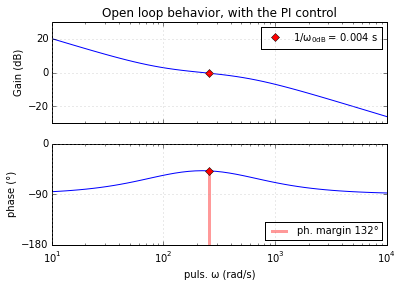

In [67]:
@interact(mL=[0., 2000*L], R=[0., 3*R], Kp=[0.,10], Ti=[0., Ti*10, Ti*.1])
def open_plot(mL=L*1000,R=R, Kp=Kp, Ti=Ti, delay=False):
    L = mL*1e-3
    sys = sig.lti([1], [L, R])
    ctrl = sig.lti([Kp*Ti, Kp], [Ti, 0])
    H_ol = ctrl.freqresp(w_list)[1] * sys.freqresp(w_list)[1]
    
    if delay:
        H_ol *= np.exp(-1j*w_list*Td)
    
    ax1, ax2 = bode_plot(w_list, dB(H_ol), deg(H_ol));
    ax1.set_title('Open loop behavior, with the PI control')
    #ax1.plot(w, dB(Kp/(w*L)), 'b--', label='Kp/Ls asympt')
    
    # phase margin
    margin, i_0dB = phase_margin(H_ol)
    w_0dB = w_list[i_0dB]
    ax1.plot(w_0dB, 0, 'rD', label='1/$\omega_{{0dB}}$ = {:.3f} s'.format(1./w_0dB))
    ax1.legend(loc='upper right', numpoints=1)
    ax1.set_ylim(-30,30)
    
    ax2.plot(w_0dB, -180+margin, 'rD')
    ax2.vlines(w_0dB, -180, -180+margin, label=u'ph. margin {:.0f}°'.format(margin),
               colors='red', linewidth=3, alpha=0.4)
    ax2.legend(loc='lower right')
    ax2.set_ylim(-180, 0)

## 4) Closed loop behavior

In the frequency domain (not so useful)

In [69]:
H_cl = H_ol/(1+H_ol)

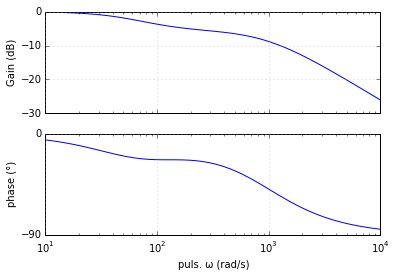

In [70]:
bode_plot(w_list, dB(H_cl), deg(H_cl));

### Time domain: transcient (step) response

In [42]:
cl_sys = sig.lti([Kp*Ti, Kp], [Ti*L,Kp*Ti + R*Ti, Kp])
cl_sys

lti(
array([[ -1.00000000e+03,  -5.00000000e+03],
       [  1.00000000e+00,   0.00000000e+00]]),
array([[ 1.],
       [ 0.]]),
array([[  500.,  5000.]]),
array([ 0.])
)

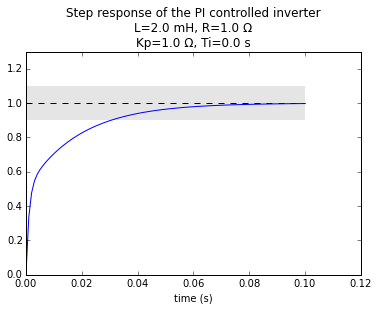

In [68]:
T_step = 0.1 #s

@interact(mL=[0., 3000*L], R=[0., 3*R], Kp=[0.,10], Ti=[0., Ti*10, Ti*.1])
def step_plot(mL=L*1000,R=R, Kp=Kp, Ti=Ti):
    L = mL*1e-3
    cl_sys = sig.lti([Kp*Ti, Kp], [Ti*L,Kp*Ti + R*Ti, Kp])
    # compute step response
    t_step = np.linspace(0, T_step, 100)
    t, h = cl_sys.step(T=t_step)
    # plot
    plt.plot(t_step, h)
    ax = plt.gca()
    ax.fill_between(t_step, 0.9, 1.1, linewidth=0, color='black', alpha=0.1)
    ax.hlines(1, t[0], t[-1], linestyles='dashed')
    title = u'''Step response of the PI controlled inverter
L={:.1f} mH, R={:.1f} Ω
Kp={:.1f} Ω, Ti={:.1f} s'''
    ax.set(title=title.format(L*1e3,R,Kp,Ti),
           xlabel = 'time (s)',
           ylim=(0, 1.3))
    

Note that the PWM delay is *not taken into account* in this transcient simulation.